In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, wasserstein_distance
from scipy.optimize import minimize
from scipy.spatial.distance import jensenshannon
import functions as f # My functions

# Context

If $X$ is a $T \times N$ matrix of i.i.d. random variables with mean 0 and variance $\sigma^2$, then the eigenvalues of the sample covariance matrix  $C = \frac{1}{T} X^T X$ asymptotically follow the Marchenko-Pastur distribution $( T, N \to \infty, 1 < \frac{T}{N} < \infty)$.

This implies that the eigenvalues of a (large) sample correlation matrix corresponding to noise should fit within the Marchenko-Pastur distribution's support, whereas eigenvalues outside of this range can be associated with signal.

This is similar to performing PCA, determinning which (small) eigenvalues can be interpreted as noise, and which (large) eigenvalues can be interpreted as meaningful structure in the data.

# Loading data and preliminary analysis

In [ ]:
# Choosing the stocks and calculating their log returns
df_stocks_info = pd.read_csv('stocks_info.csv')
chosen_assets = df_stocks_info['symbol'] # We choose all data

df_returns = f.calculate_returns(chosen_assets=chosen_assets, min_obs_threshold = 0.65)
df_returns = df_returns.drop(columns=['GOOGL', 'FOXA'])
print(f'df_returns shape: (T, N) = {df_returns.shape}')

# Checking the assumption
T, N = df_returns.shape
print(f'T > N assumption satisfied: {T > N}')

        Asset 1    Asset 2      Corr
175680     GOOG      GOOGL  0.995705
164780      FOX       FOXA  0.989892
265325   ^GDAXI  ^STOXX50E  0.963674
265167     ZF=F       ZN=F  0.952140
181511  HEIA.AS    HEIO.AS  0.947834
180690      HEI      HEI-A  0.941202
265330    ^GSPC      ^IXIC  0.937324
265355     ^TNX       ^TYX  0.929280
265170     ZF=F       ZT=F  0.926039
49370       AVB        EQR  0.925389
df_returns shape: (T, N) = (798, 728)
T > N assumption satisfied: True


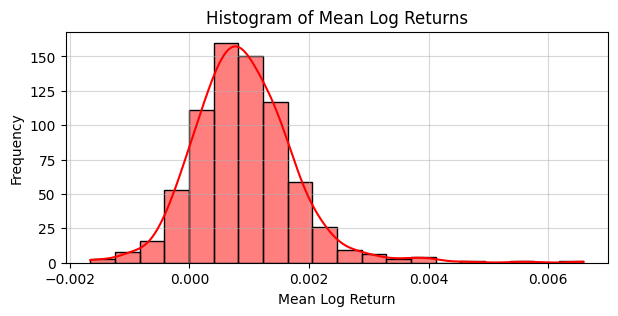

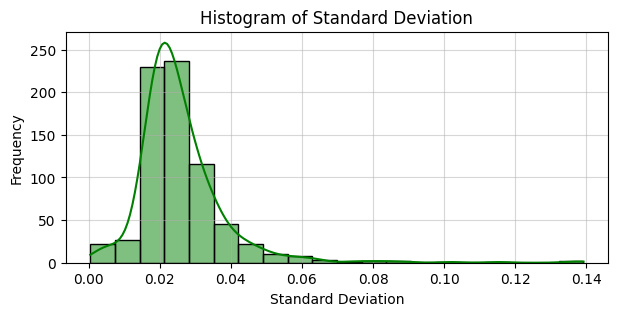

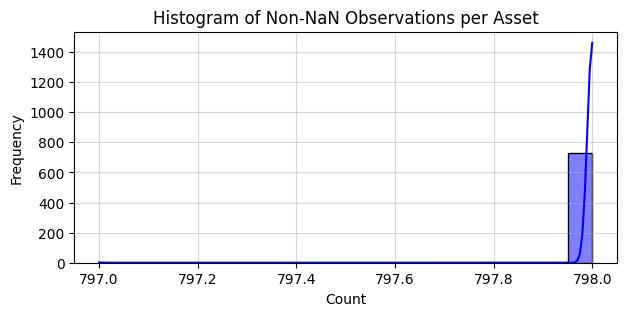

In [3]:
# Computing summary statistics
desc_stats = df_returns.describe().T

def plot_histogram(stat_name, bins, color, title, xlabel):
    plt.figure(figsize=(7, 3))
    sns.histplot(desc_stats[stat_name], bins=bins, kde=True, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.grid(alpha=0.5)
    plt.show()

plot_histogram('mean', 20, 'red', 'Histogram of Mean Log Returns', 'Mean Log Return')
plot_histogram('std', 20, 'green', 'Histogram of Standard Deviation', 'Standard Deviation')
plot_histogram('count', 20, 'blue', 'Histogram of Non-NaN Observations per Asset', 'Count')

# Denoising the correlation matrix

First we fit the Marchenko-Pastur distribution. Then we replace all eigenvalues associated with noise (within the Marchenko-Pastur support) by their mean.

### Fitting the Marchenko-Pastur distribution

Ratio of eigenvalues associated with noise: 92.58%


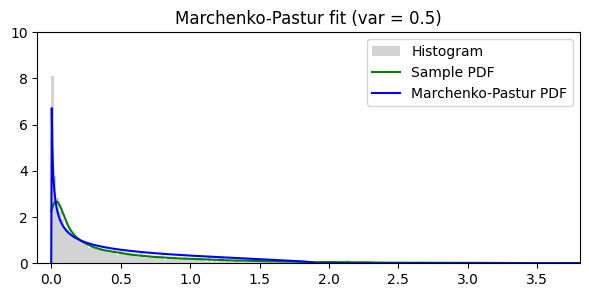

In [4]:
def mp_pdf(var, T, N, x = None):
    # Marchenko-Pastur density and support. x is a ndarray.

    support_min = var * (1 - (N/T)**0.5)**2
    support_max = var * (1 + (N/T)**0.5)**2

    if x is not None:
        pdf = np.zeros_like(x, dtype=float)

        support = (x >= support_min) & (x <= support_max)
        pdf[support] = T/N * ((support_max - x[support])*(x[support] - support_min))**0.5
        pdf[support] = pdf[support] / (2 * np.pi * x[support] * var)
    else:
        pdf = None

    return pdf, support_min, support_max


def get_eigen_decomp(corr_matrix):
    # Get sorted eigenvalue decomposition

    eigenvalues, eigenvectors = np.linalg.eigh(corr_matrix)

    sorted_eigen_indices = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[sorted_eigen_indices]
    eigenvectors = eigenvectors[:,sorted_eigen_indices]

    return eigenvalues, eigenvectors


def get_eigen_pdf(eigenvalues, kde_bw = None):
    # Get the pdf and support of the eigenvalues of the sample correlation matrix

    support_min = eigenvalues.min()
    support_max = eigenvalues.max()
    
    if kde_bw is not None:
        pdf = gaussian_kde(eigenvalues[1:], bw_method=kde_bw)
    else:
        pdf = gaussian_kde(eigenvalues[1:], bw_method='scott')

    return pdf, support_min, support_max

def wass_dist(eigen_pdf, support_min, support_max, T, N, var):
    # Wasserstein distance between two distributions (handles the different supports)

    x_vals = np.linspace(support_min, support_max, 1000)
    p_x = eigen_pdf(x_vals)  # Target density
    q_x = mp_pdf(var, T, N, x_vals)[0]  # Model density

    wasserstein = wasserstein_distance(np.sort(p_x), np.sort(q_x))

    return wasserstein

def fit_mp_distr(eigenvalues, T, N, kde_bw = None):
    # Fit the Marchenko-Pastur distribution to the empirical eigenvalues

    eigen_pdf, _, eigen_support_max = get_eigen_pdf(eigenvalues, kde_bw)

    out = minimize(lambda var0: wass_dist(
        eigen_pdf, 0, eigen_support_max, T, N, var0), 0.5, bounds=[(1E-10, 10)])
    
    var0 = out['x'][0]

    return var0

def plot_mp_calibration(eigenvalues, var0, T, N, kde_bw):
    # A visualisation of how well the calibration went

    eigen_pdf, _, _ = get_eigen_pdf(eigenvalues, kde_bw)
    _, _, mp_support_max = mp_pdf(var0, T=T, N=N)

    x_vals = np.linspace(0, 2 * mp_support_max, 1000)

    plt.figure(figsize=(7, 3))
    plt.xlim(-0.1, 2 * mp_support_max)
    plt.ylim(top=10)
    plt.hist(eigenvalues, density=True, bins=10000, color = 'lightgray', label = 'Histogram')
    plt.plot(x_vals, eigen_pdf(x_vals), color = 'green', label = 'Sample PDF')
    plt.plot(x_vals, mp_pdf(var0, T=T, N=N, x=x_vals)[0], color = 'blue', label = 'Marchenko-Pastur PDF')
    plt.title(f"Marchenko-Pastur fit (var = {round(var0, 2)})")
    plt.legend()
    

corr_matrix = df_returns.corr()

eigenvalues, eigenvectors = get_eigen_decomp(corr_matrix)

kde_bw = 0.02 # Fitting sample PDF hyparparameter (visually, so sample PDF is in line with the histogram)

var0 = fit_mp_distr(eigenvalues, T, N, kde_bw = kde_bw) # Fitting variance of the Marchenko-Pastur dist.

plot_mp_calibration(eigenvalues, var0, T, N, kde_bw) # Visual inspections of the results

_, support_min, support_max = mp_pdf(var0, T, N)

print(f'Ratio of eigenvalues associated with noise: {np.round(100*np.sum(eigenvalues < support_max)/N, 2)}%')

### Calculating the denoised correlation matrix

In [5]:
# Check the correlation matrix reconstruction works
print('* Checking if the reconstruction caused no errors: \n')
print(corr_matrix.iloc[:5,:5])
reconstructed_corr_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
print('\n')
print(reconstructed_corr_matrix[:5,:5])
print(f'\nTrace of original corr matrix: {np.diag(corr_matrix).sum()}')
print(f'\nTrace of reconstructed corr matrix: {np.diag(reconstructed_corr_matrix).sum()}')

# Defining the denoised correlation matrix
def denoise_corr_matrix(eigenvalues, eigenvectors, var0, T, N):
    # Calculate the denoised correlation matrix
    _, _, support_max = mp_pdf(var0, T, N)

    # Step 1: Replace noise with its mean (0 is also an option, but the trace would change)
    denoised_eigenvalues = eigenvalues.copy()
    denoised_eigenvalues[eigenvalues < support_max] = \
        eigenvalues[eigenvalues < support_max].mean()
    
    # Step 2: Calculate the denoised covariance matrix
    denoised_cov_matrix = eigenvectors @ np.diag(denoised_eigenvalues) @ eigenvectors.T
    
    # Step 3: Transform this covariance matrix to a correlation matrix
    diag_dcm = np.diag(denoised_cov_matrix)
    denoised_corr_matrix = \
        denoised_cov_matrix * (np.outer(diag_dcm ** 0.5, diag_dcm ** 0.5) ** (-1))
    
    # Step 4: Removing numerical errors
    denoised_corr_matrix[denoised_corr_matrix > 1] = 1
    denoised_corr_matrix[denoised_corr_matrix < -1] = -1
    
    return denoised_corr_matrix

print(f'\nDenoised corr matrix (first 5 assets):\n')
denoised_corr_matrix = denoise_corr_matrix(eigenvalues, eigenvectors, var0, T, N)
print(denoised_corr_matrix[:5, :5])

* Checking if the reconstruction caused no errors: 

Symbol     000001.SS         A      AAPL      ABBV    ABI.BR
Symbol                                                      
000001.SS   1.000000  0.150305  0.127528  0.032402  0.062917
A           0.150305  1.000000  0.375314  0.215910  0.129553
AAPL        0.127528  0.375314  1.000000  0.112053  0.037070
ABBV        0.032402  0.215910  0.112053  1.000000  0.094540
ABI.BR      0.062917  0.129553  0.037070  0.094540  1.000000


[[1.         0.15030532 0.12752768 0.03240157 0.06291719]
 [0.15030532 1.         0.37531407 0.21591    0.12955312]
 [0.12752768 0.37531407 1.         0.11205331 0.03706974]
 [0.03240157 0.21591    0.11205331 1.         0.09454004]
 [0.06291719 0.12955312 0.03706974 0.09454004 1.        ]]

Trace of original corr matrix: 728.0

Trace of reconstructed corr matrix: 728.0000000000003

Denoised corr matrix (first 5 assets):

[[1.         0.15904377 0.13408518 0.03366779 0.06653857]
 [0.15904377 1.         0.34953606 

# Detoning the correlation matrix

The largest eigenvector is often referred to as the market component. It is usefull to remove it for e.g. clustering, because the clusters will become more distinct. The matrix will become singular, so it can't be used directly for e.g. mean-variance portfolio optimization.

This is equivalent to removing the largest (or few largest) PCA components to focus on more granular, e.g. sector-specific structures, rather than broad market movements.

In [6]:
def detone_corr_matrix(denoised_corr_matrix):
    # Detoning the correlation matrix

    # Calculating the detoned covariance matrix
    eigenvalues, eigenvectors = get_eigen_decomp(denoised_corr_matrix)
    eigenvalues[0] = 0 # Setting the market component to 0
    detoned_cov_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

    # Transforming the covariance to a correlation matrix
    diag_dtm = np.diag(detoned_cov_matrix)
    detoned_corr_matrix = \
        detoned_cov_matrix * (np.outer(diag_dtm ** 0.5, diag_dtm ** 0.5) ** (-1))
    
    return detoned_corr_matrix

detoned_corr_matrix = detone_corr_matrix(denoised_corr_matrix)

print(f'Rank of original corr matrix: {np.linalg.matrix_rank(corr_matrix)}')
print(f'Rank of denoised corr matrix: {np.linalg.matrix_rank(denoised_corr_matrix)}')
print(f'Rank of detoned corr matrix: {np.linalg.matrix_rank(detoned_corr_matrix)}')

print('\nDetoned corr matrix (first 5 assets):')
print(detoned_corr_matrix[:5, :5])

Rank of original corr matrix: 728
Rank of denoised corr matrix: 728
Rank of detoned corr matrix: 727

Detoned corr matrix (first 5 assets):
[[ 1.          0.07830847  0.05962963 -0.01538539  0.01806528]
 [ 0.07830847  1.          0.057422    0.0669654  -0.08314629]
 [ 0.05962963  0.057422    1.         -0.02056242 -0.15368425]
 [-0.01538539  0.0669654  -0.02056242  1.         -0.00464332]
 [ 0.01806528 -0.08314629 -0.15368425 -0.00464332  1.        ]]


In [7]:
# Saving the denoised and detoned correlactions of returns
pd.DataFrame(detoned_corr_matrix, index = corr_matrix.index, columns = corr_matrix.columns).to_csv('denoised_and_detoned_corr_matrix.csv', index=True)